In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)
print(x_train)

(550, 300)
[[-1.293864    0.26688415  0.17891383 ... -1.1692238  -0.10237546
   0.58351785]
 [-0.5219885   1.2065896   1.1948192  ... -1.7902911   0.94060045
  -0.1277058 ]
 [ 0.65403384  1.0049634  -0.6513554  ... -1.773319    0.4276662
   2.5392776 ]
 ...
 [ 0.6640236   0.3192     -0.28298047 ...  0.585824    0.76983005
   0.84620374]
 [ 0.5247948   0.8323696   1.855217   ...  0.7948658  -1.2047578
   1.8342754 ]
 [ 0.03478426  1.8195775   0.68849623 ...  1.4219252  -1.4674224
  -0.18993278]]


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    num_sample = len(y_train)
    total = [i for i in range(num_sample)]
    np.random.shuffle(total)
    count = 0
    k_fold = []
    for i in range(k):
        if i < num_sample % k:
            num = num_sample//k + 1
        else:
            num = num_sample//k
        test_idx = total[count:count+num]
        test_idx.sort()
        test_idx = np.array(test_idx)
        train_idx = [i for i in range(num_sample) if i not in test_idx]
        train_idx.sort()
        train_idx = np.array(train_idx)
        k_fold.append([train_idx, test_idx])   # k_fold必須是nparray才有shape
        count += num
    k_fold = np.array(k_fold)
    return k_fold

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10   # should contain 10 fold of data
assert len(kfold_data[0]) == 2   # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55   # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data = []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19], Validation index: [ 1  5  8 14]
Split: 2, Training index: [ 1  2  3  4  5  6  7  8  9 10 11 12 14 15 17 18], Validation index: [ 0 13 16 19]
Split: 3, Training index: [ 0  1  4  5  7  8  9 10 12 13 14 15 16 17 18 19], Validation index: [ 2  3  6 11]
Split: 4, Training index: [ 0  1  2  3  5  6  7  8  9 10 11 13 14 15 16 19], Validation index: [ 4 12 17 18]
Split: 5, Training index: [ 0  1  2  3  4  5  6  8 11 12 13 14 16 17 18 19], Validation index: [ 7  9 10 15]


In [8]:
X = np.arange(20)    # 寫一個測試自己cross_validation的函數
kf = cross_validation(X, X, 5)
kfold_data = []
for i in range(5):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, kf[i][0], kf[i][1]))
kfold_data = kf.copy()

Split: 1, Training index: [ 1  2  3  4  5  7  8  9 10 11 14 15 16 17 18 19], Validation index: [ 0  6 12 13]
Split: 2, Training index: [ 0  2  3  4  5  6  8 11 12 13 14 15 16 17 18 19], Validation index: [ 1  7  9 10]
Split: 3, Training index: [ 0  1  2  4  6  7  8  9 10 11 12 13 14 15 17 18], Validation index: [ 3  5 16 19]
Split: 4, Training index: [ 0  1  2  3  4  5  6  7  9 10 12 13 16 17 18 19], Validation index: [ 8 11 14 15]
Split: 5, Training index: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 15 16 19], Validation index: [ 2  4 17 18]


In [9]:
assert len(kfold_data) == 5   # should contain 5 fold of data
assert len(kfold_data[0]) == 2   # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4   # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [10]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)
C = [10 ** i for i in range(-2, 5)]   # 由下面範例的表得出
G = [10 ** i for i in range(-4, 4)]

In [11]:
## your code
def grid_search(x_train, y_train, cla, k):
    best_score = 0
    score_table = np.zeros((7, 8))   # 下面畫表要用
    k_fold = cross_validation(x_train, y_train, k)
    new_x_train = []
    new_y_train = []
    new_x_test = []
    new_y_test = []
    for i in range(k):
        new_x_train.append([x_train[j] for j in k_fold[i][0]])
        new_y_train.append([y_train[j] for j in k_fold[i][0]])
        new_x_test.append([x_train[j] for j in k_fold[i][1]])
        new_y_test.append([y_train[j] for j in k_fold[i][1]])
    for i in range(len(C)):
        for j in range(len(G)):
            if cla:
                clf = SVC(C=C[i], kernel='rbf', gamma=G[j])
            else:
                clf = SVR(C=C[i], kernel='rbf', gamma=G[j])   # 為了之後的regression
            total_score = []
            for t in range(k):
                clf.fit(new_x_train[t], new_y_train[t])
                total_score.append(clf.score(new_x_test[t], new_y_test[t]))
            score = np.mean(total_score)
            
            if score > best_score:
                best_score = score
                best_parameters = {"C": C[i], "gamma": G[j]}
            score_table[i][j] = score
    return best_parameters, score_table

In [12]:
best_parameters, score_table = grid_search(x_train, y_train, True, 5)
print(best_parameters)

{'C': 10, 'gamma': 0.001}


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like the reference image ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

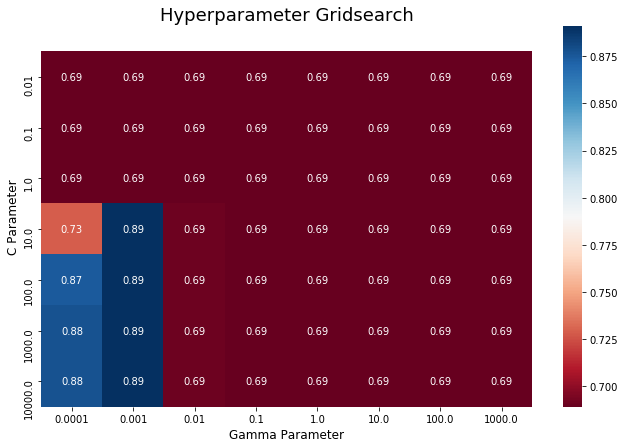

In [13]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

table = pd.DataFrame(score_table, index=C, columns=G)
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Hyperparameter Gridsearch', fontsize=18)
sn.heatmap(table, annot=True, cmap="RdBu")
ax.set_xlabel('Gamma Parameter', fontsize=12)
ax.set_ylabel('C Parameter', fontsize=12)
plt.ylim(len(score_table), -0.5)
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [14]:
best_model = SVC(C=best_parameters['C'], kernel='rbf', gamma=best_parameters['gamma'])
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of each model you have implemented from HW1

### HW1

In [15]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1, 1)
y_train = train_df['y_train'].to_numpy().reshape(-1, 1)
test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1, 1)
y_test = test_df['y_test'].to_numpy().reshape(-1, 1)

In [16]:
def gradient_descent(X, y, theta, learning_rate=1e-4, iterations=100):
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations, 2))
    for it in range(iterations):   
        prediction = np.dot(X, theta)
        theta = theta - learning_rate*((X.T).dot((prediction - y)))
        cost_history[it] = cal_cost(theta, X, y)
    return theta, cost_history

In [17]:
def cal_cost(theta, X, y):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/2) * np.sum(np.square(predictions-y))
    return cost

In [18]:
theta = np.random.rand(2, 1)
l_r = 1e-4
n_iter = 100
X_b = np.c_[np.ones((len(x_train), 1)), x_train]    # 全部補1才可以用內積算
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)  #先用公式解算算答案
print(theta_best)
'''print(X_b.shape)'''
theta, cost_history = gradient_descent(X_b, y_train, theta, l_r, n_iter)    

[[0.78456508]
 [0.81797038]]


In [24]:
X_test_b = np.c_[np.ones((len(x_test), 1)), x_test]    # 全部補1才可以用內積算
y_pred_HW1 = np.dot(X_test_b, theta)
MSE_HW1 = 0.0
MSE_HW1 = cal_cost(theta, X_test_b, y_test)

In [25]:

y_train = np.squeeze(y_train.T)  # 變成一維
best_parameters, score_table = grid_search(x_train, y_train, cla=0, k=5)
print(best_parameters)
model = SVR(C=best_parameters['C'], kernel='rbf', gamma=best_parameters['gamma'])
model.fit(x_train, y_train)

{'C': 1000, 'gamma': 0.001}


SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

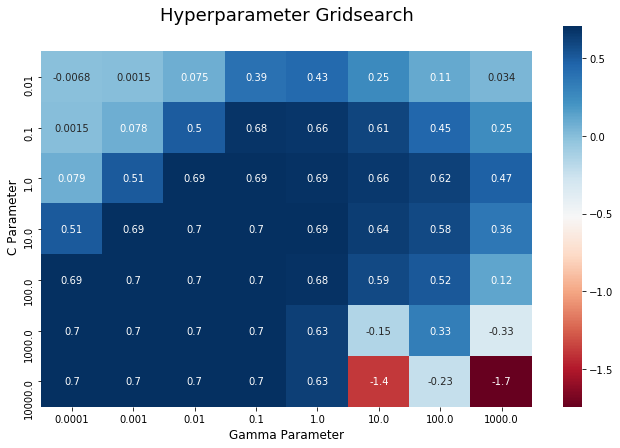

In [26]:
table = pd.DataFrame(score_table, index=C, columns=G)
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Hyperparameter Gridsearch', fontsize=18)
sn.heatmap(table, annot=True, cmap="RdBu")
ax.set_xlabel('Gamma Parameter', fontsize=12)
ax.set_ylabel('C Parameter', fontsize=12)
plt.ylim(len(score_table), -0.5)
plt.show()  
# 這裡使用的score不是MSE，是SVR裡定義的score，score = 1-(u/v)
# u = ((y_true - y_pred) ** 2).sum()
# v = ((y_true - y_true.mean()) ** 2).sum().
# The best possible score is 1.0(when u is 0) and it can be negative (because the model can be arbitrarily worse). 


In [27]:
y_pred_HW4 = model.predict(x_test)
MSE_HW4 = 0
for i in range(len(y_test)):
    MSE_HW4 = MSE_HW4 + (y_pred_HW4[i]-y_test[i])**2
MSE_HW4 /= 2
MSE_HW4 = np.squeeze(MSE_HW4)

In [28]:
print("Square error of Linear regression: ", MSE_HW1)   # 這裡使用的MSE是(1/2) * 殘差平方和
print("Square error of SVM regresssion model: ", MSE_HW4)

Square error of Linear regression:  3.4339477869026385
Square error of SVM regresssion model:  3.6002184676788693
